In [1]:
# No need to donwload datasets, its already in /dataset/Tiny-ImageNet/tiny-imagenet-200/
# !cd /tmp; wget --quiet http://pages.ucsd.edu/~ztu/courses/tiny-imagenet-200.zip
# !cd /tmp; unzip -qq tiny-imagenet-200.zip; rm tiny-imagenet-200.zip

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras import optimizers
import os
import math
import numpy as np
import scipy
import random
from PIL import Image
import json
from matplotlib import pyplot as plt
from pandas import Series, DataFrame
import datetime

Using TensorFlow backend.


## Setting up paths

In [2]:
import glob

# path = "/tmp/tiny-imagenet-200/"
path = "/datasets/Tiny-ImageNet/tiny-imagenet-200/"
train_dirs = glob.glob(path + "train/*")
val_dirs   = glob.glob(path + "val/*")
test_dirs  = glob.glob(path + "test/*")

n_samples  = 100000
used_labels =  [ d[-9:] for d in train_dirs ]     # There are only 200 used labels in both training and validation
len(used_labels)

from sklearn.preprocessing import LabelBinarizer # Hot-Encode Labels
bin_encoder = LabelBinarizer()
bin_encoder.fit_transform(used_labels).size

def get_image(img_path):                         # Helper Functions
    img = img_to_array(load_img(img_path))
    return img / 255.0

def get_images(paths):
    n = len(paths)
    X = np.empty(shape=(n, 64,64,3))
    for i,p in enumerate(paths):
        X[i, ...] = get_image(p)
    return X

def shuffle(*args):
    fusion = list(zip(*args))
    np.random.shuffle(fusion)
    return zip(*fusion)
    
def plot_history(history, model_path, title):
    # Get training and test loss histories
    training_loss = history.history['loss']
    val_loss     = history.history['val_loss']
    training_acc  = history.history['acc']
    val_acc       = history.history['val_acc']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

    ax1.plot(epoch_count, training_loss, 'r--')
    ax1.plot(epoch_count, val_loss, 'b-')
    ax1.legend(['Training Loss', 'Validation Loss'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.plot(epoch_count, training_acc, 'r--')
    ax2.plot(epoch_count, val_acc, 'b-')
    ax2.legend(['Training Acc', 'Validation Acc'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    plt.title(title, loc='right')
    f.savefig(model_path + '.png')
    plt.show()
    
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

# Getting All Data

In [4]:
## Getting Training Data

train_data_paths, train_labels = [],[]
train_images = np.empty(shape=(n_samples, 64, 64, 3))

for class_path in train_dirs:
    class_name = class_path[-9:]
    images = glob.glob(class_path + '/images/*')
    for image_path in images:
        train_labels    .append( class_name )
        train_data_paths.append( image_path )
        
train_labels, train_data_paths = shuffle(train_labels, train_data_paths)
train_labels = bin_encoder.transform(train_labels) # hot-encode labels from string to number
for i,img_path in enumerate(train_data_paths):     # Load images
    img = get_image(img_path)
    train_images[i, ...] = img
print(len(train_data_paths), train_labels.shape)   # sanity check

## Getting Validation Data
val_labels, val_images_paths = [], []
for line in open(path + 'val/val_annotations.txt'):
    [fn, classname, _ , _, _, _ ] = line.strip().split('\t')
    val_images_paths.append(path +'val/images/' + fn )
    val_labels.append(classname)                   # 10K images probably fit in RAM

val_labels = bin_encoder.transform(val_labels)    # hot-encode labels from string to number
val_images = get_images(val_images_paths)         # use helper function to get all images
print(val_images.shape, val_labels.shape)         # sanity check

100000 (100000, 200)
(10000, 64, 64, 3) (10000, 200)


### Preparing Model (Change Parameters Manually)

In [6]:
# from kernet import resnet
# from vgg16_keras import VGG_16

def add_conv_layer(model, activation, channel_size=16, filter_size=3, input_shape=None, batch_normalization=False):
    if input_shape:
        model.add(Conv2D(channel_size,
                         (filter_size,filter_size),
                         padding='same',
                         input_shape=input_shape))
    else:
        model.add(Conv2D(channel_size, (filter_size,filter_size), padding='same',))
    if batch_normalization:
        model.add(BatchNormalization())
    model.add(Activation(conv_layer_activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

In [8]:
n_classes  = 200
model = Sequential()

filter_size = 3    # originally, it was 3
conv_layer_activation = 'relu'  # by default, its relu

add_conv_layer(model, conv_layer_activation, 16, filter_size, (64,64,3)) # conv1
add_conv_layer(model, conv_layer_activation, 16, filter_size, batch_normalization=True) # conv2
add_conv_layer(model, conv_layer_activation, 16, filter_size, batch_normalization=True) # conv2-extra
add_conv_layer(model, conv_layer_activation, 32, filter_size, batch_normalization=True) # conv3
add_conv_layer(model, conv_layer_activation, 32, filter_size, batch_normalization=True) # conv4
add_conv_layer(model, conv_layer_activation, 64, filter_size, batch_normalization=True) # conv5

model.add(Flatten())

# fc1
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# fc1-extra
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# fc2
model.add(Dense(n_classes))
model.add(Activation('softmax'))

# del model; model = resnet.ResnetBuilder.build((3, 64, 64), 200, 'basic_block', [2, 2, 2, 2])
# del model; model = VGG_16()

# optz = SGD(lr=0.01, momentum=0.9)                                                     # default
# optz = SGD(lr=0.01, momentum=0.9, nesterov=True)
# optz = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)                # https://keras.io/optimizers/
# optz = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
optz = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=optz, metrics=['accuracy'])

layer_counts = Series([ c['class_name'] for c in model.get_config()]).value_counts()    # layer counts
display(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
activation_10 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
__________

None

In [19]:
# Settings
epochs = 50
batch_size = 128
optz_name = str(optz.__class__)[25:-2]
experiement_config = {
    'epochs': epochs, 'batch_size': 128, 'activation': conv_layer_activation, 'optimizer': optz_name, 
}

print('memory usage : {} GB'.format(get_model_memory_usage(batch_size=batch_size, model=model)))
note  = 'Major Tweaks #2(10+30+50+50) (activation:{}, opt:{}, filter_size:{}, Conv2D_counts:{}, FC_counts:{})'.format(
    conv_layer_activation, optz_name, filter_size, layer_counts['Conv2D'], layer_counts['Dense']
)
note

memory usage : 0.462 GB


'Major Tweaks #2(10+30+50+50) (activation:relu, opt:Adam, filter_size:3, Conv2D_counts:6, FC_counts:3)'

In [ ]:
# note = 'Model 1: Default Original Params (10 Epoch)'
# note = 'Model 2: default model 64 batch size (10 Epoch)'
# note = 'Model 3: 128 batch size, with STG-Neterov (10 Epoch)'
# note = 'Model default (activation:{})'.format(conv_layer_activation)
# note = 'Model VGG-16'


try:
    history = model.fit(train_images,
                        train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_images, val_labels),
                        shuffle=True)
    date_string = datetime.datetime.now().strftime("%a_%H_%M")
    model_path = 'models/model_' + date_string + '_' + str(epochs) + 'epc'

    model.save(model_path + '.h5')                                    # creates a HDF5 file 'cnn_model.h5'
    plot_history(history=history, model_path=model_path, title=note)  # plot, and sve to .png
    with open(model_path + '.txt','w') as fh:                         # save useful info to .txt
        fh.write('Epochs: ' + str(epochs) + '\n')
        fh.write('Final validation acc: ' + str(history.history['val_acc'][-1]) + '\n')
        fh.write('Note: ' + note + '\n')
        model.summary(print_fn=lambda x: fh.write(x + '\n'))
        
    with open(model_path + '.json', 'w') as fp:           # save experiment settings to .json
        for h in history.history:
            experiement_config[h] = history.history[h] # copying history content to json file
        json.dump(experiement_config, fp, indent=4)
except Exception as e:
    raise e

Train on 100000 samples, validate on 10000 samples
Epoch 1/50
100000/100000 [==============================] - 98s - loss: 2.2858 - acc: 0.4189 - val_loss: 3.0753 - val_acc: 0.3052
Epoch 2/50
100000/100000 [==============================] - 104s - loss: 2.2827 - acc: 0.4182 - val_loss: 3.1716 - val_acc: 0.2904
Epoch 3/50
100000/100000 [==============================] - 99s - loss: 2.2784 - acc: 0.4182 - val_loss: 3.0678 - val_acc: 0.3058
Epoch 4/50
100000/100000 [==============================] - 100s - loss: 2.2680 - acc: 0.4202 - val_loss: 3.0146 - val_acc: 0.3155
Epoch 5/50
100000/100000 [==============================] - 98s - loss: 2.2713 - acc: 0.4175 - val_loss: 3.1038 - val_acc: 0.3038
Epoch 6/50
100000/100000 [==============================] - 92s - loss: 2.2686 - acc: 0.4183 - val_loss: 3.2072 - val_acc: 0.2866
Epoch 7/50
100000/100000 [==============================] - 99s - loss: 2.2618 - acc: 0.4198 - val_loss: 3.0633 - val_acc: 0.3135
Epoch 8/50
100000/100000 [===========

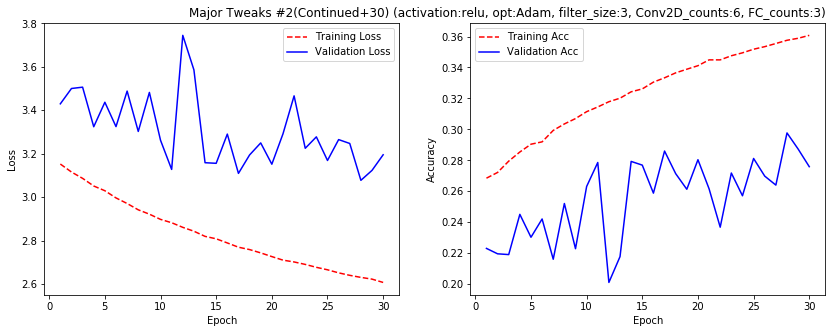

In [16]:
plot_history(history=history, model_path=model_path, title=note)  # plot, and sve to .png

In [43]:
del model

# Established Models

# Unused Code

### Plot Accuracy History

In [5]:
def prepare_batch(X,y,batch_size=50):
    N = len(y) / batch_size
    i = 0
    yield X[:batch_size], y[:batch_size]
    i += 1
    while i < N:
        yield X[batch_size*i:batch_size*(i+1)], y[batch_size*i:batch_size*(i+1)]
        i = i + 1

In [7]:
import time
time.sleep(2)

<IPython.core.display.Javascript object>

In [ ]:
# SNAPSHOT Of PRevious Default structure

# Default is 5 2DConv and 2 FC
add_conv_layer(model, conv_layer_activation, 16, filter_size, (64,64,3)) # conv1
add_conv_layer(model, conv_layer_activation, 16, filter_size, batch_normalization=True) # conv2
add_conv_layer(model, conv_layer_activation, 32, filter_size, batch_normalization=True) # conv3
add_conv_layer(model, conv_layer_activation, 32, filter_size, batch_normalization=True) # conv4
add_conv_layer(model, conv_layer_activation, 32, filter_size, batch_normalization=True) # conv5

# fc1
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.4))

# fc2
model.add(Dense(n_classes))
model.add(Activation('softmax'))